In [142]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
# Importing essential libraries
import os
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,
    mean_poisson_deviance, mean_gamma_deviance, accuracy_score
)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Dropout, Dense, BatchNormalization, Bidirectional, Conv1D, 
    MaxPooling1D, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

import datetime

In [144]:
df = pd.read_csv('Tesla.csv')
df.shape

(2274, 7)

In [145]:
df.drop(['Unnamed: 0'], axis=1, inplace=True, errors='ignore')
df.drop(['Unnamed: 0'], axis=0, inplace=True, errors='ignore')

df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


In [146]:
df.set_index('Date', inplace=True)

In [147]:
# resorting the data
df.index =  pd.to_datetime(df.index,format='%Y-%m-%d')

In [148]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


In [149]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-09,238.110001,238.960007,232.039993,234.960007,96705700
2024-01-10,235.100006,235.500000,231.289993,233.940002,91628500
2024-01-11,230.570007,230.929993,225.369995,227.220001,105873600
2024-01-12,220.080002,225.339996,217.149994,218.889999,122889000
2024-01-16,215.100006,223.490005,212.180099,219.910004,115064708


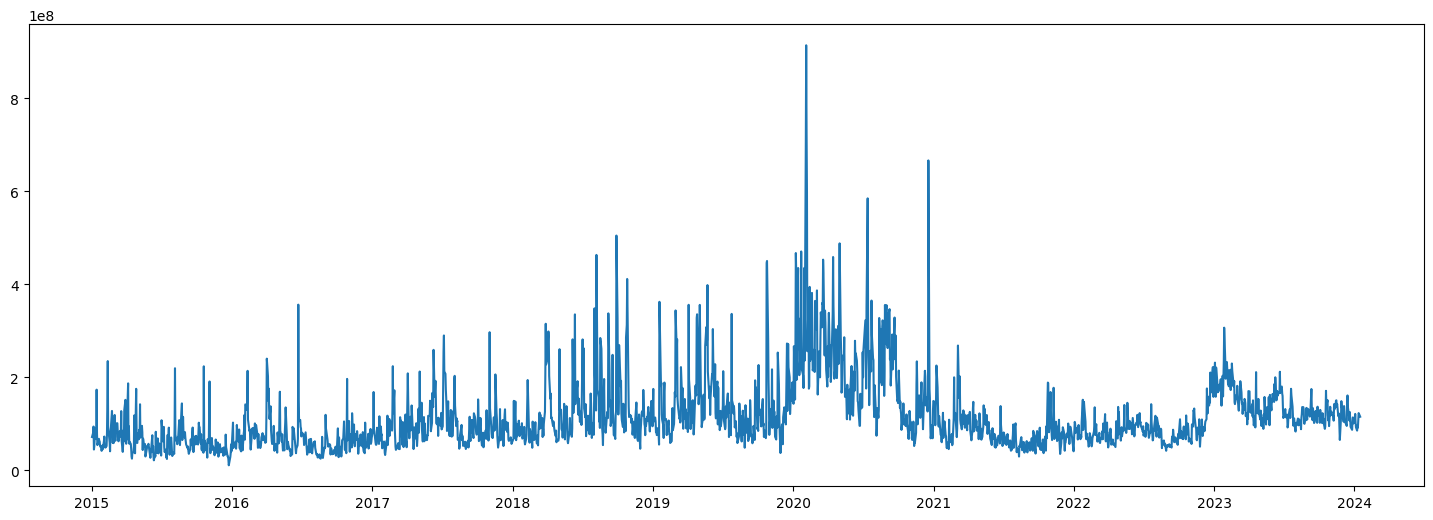

In [150]:
# volume = amount of stock traded during that day
plt.figure(figsize=(18, 6))
plt.plot(df['Volume'])   

Text(0.5, 1.0, 'Tesla Stock Price Graph')

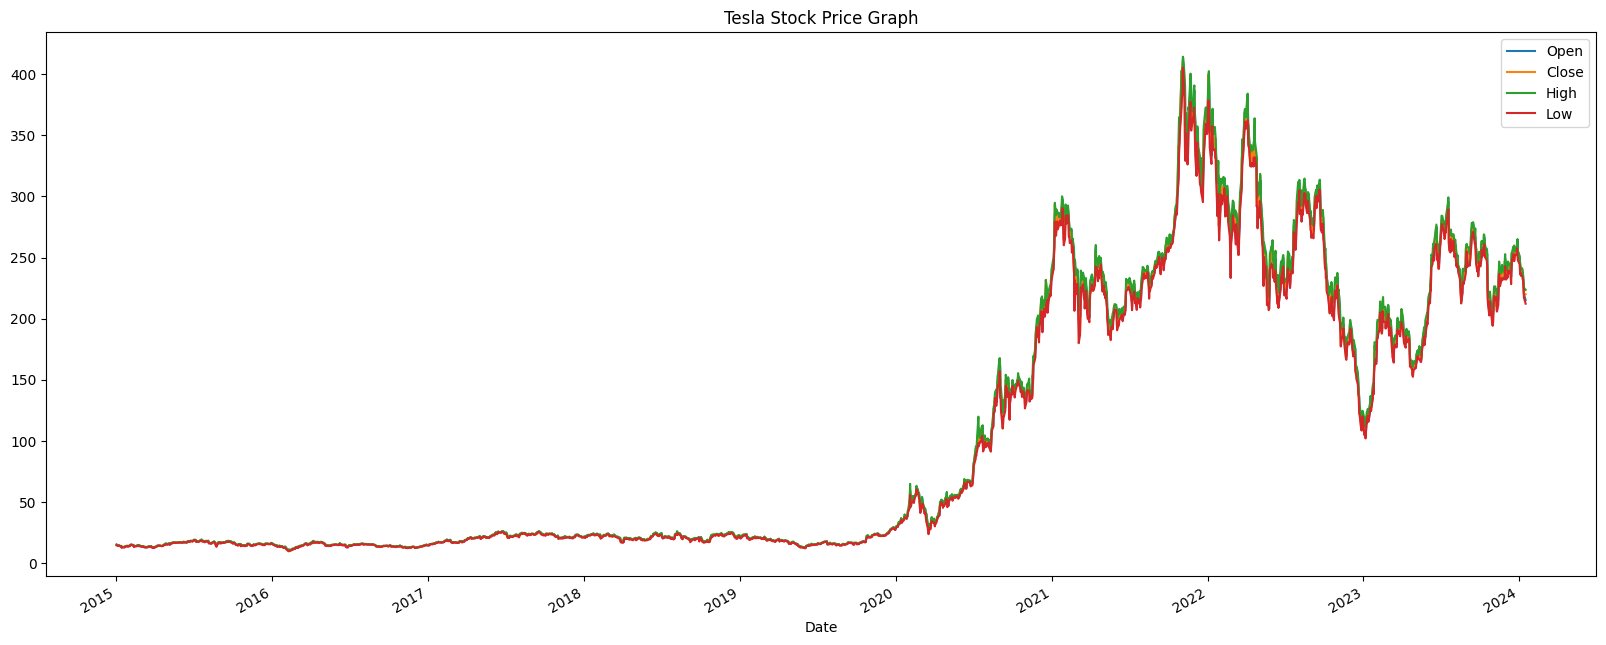

In [151]:
df[['Open', 'Close', 'High', 'Low']].plot(figsize=(20, 8))
plt.title('Tesla Stock Price Graph')

Text(0.5, 1.0, 'Tesla Stock Price in last years')

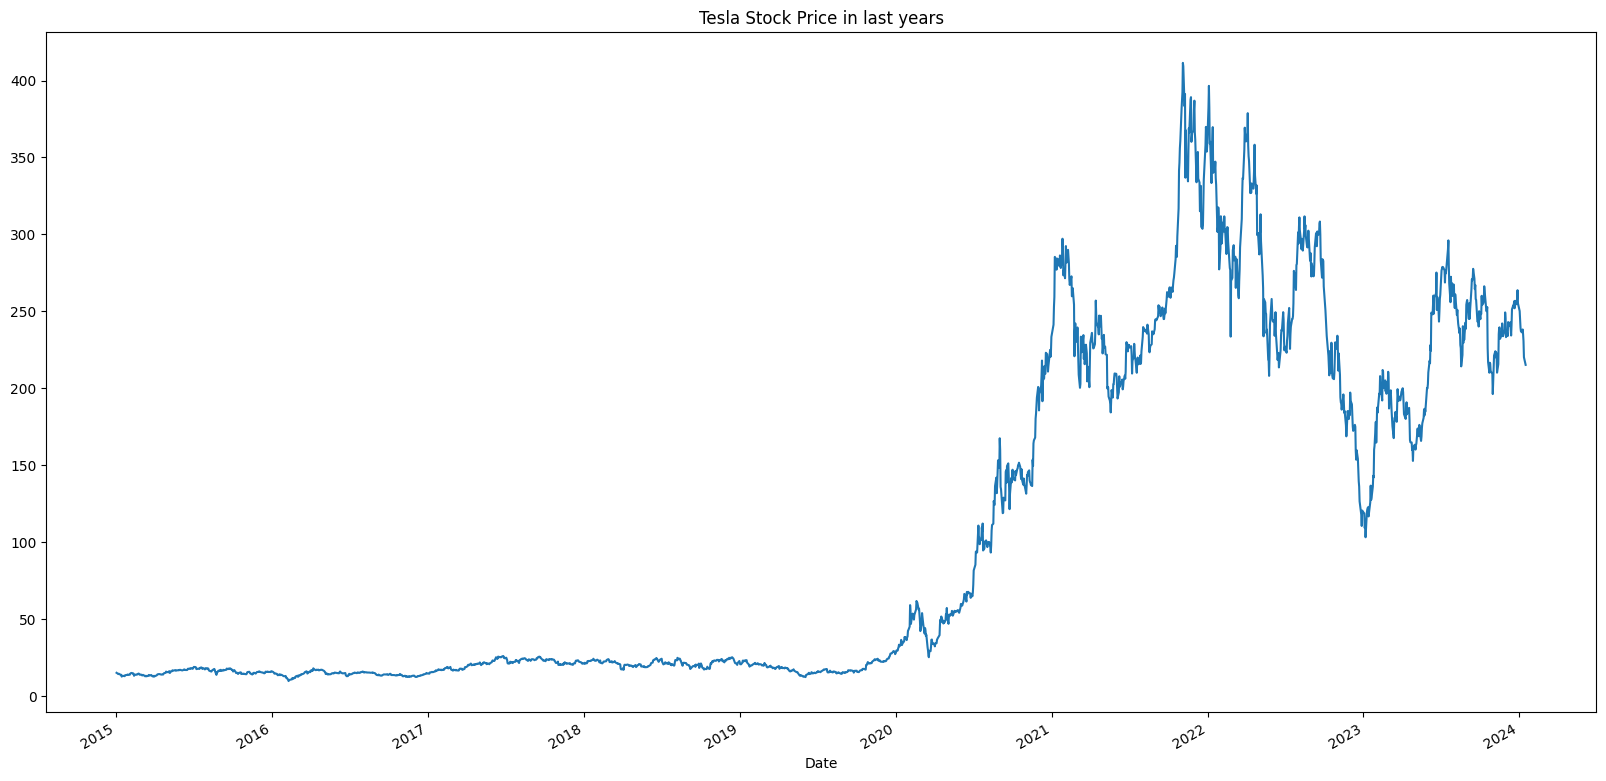

In [152]:
prev = df['2015':'2024']

prev['Open'].plot(figsize=(20, 10), alpha=1)
plt.title("Tesla Stock Price in last years")

In [153]:
prev.describe()

,Open,High,Low,Close,Volume
count,2274.000000,2274.000000,2274.000000,2274.000000,2.274000e+03
mean,103.493730,105.771617,101.036327,103.461794,1.142089e+08
std,111.136174,113.606095,108.399966,111.032019,7.688430e+07
min,9.488000,10.331333,9.403333,9.578000,1.062000e+07
25%,16.669833,16.933332,16.468833,16.693666,6.637762e+07
50%,23.221334,23.554000,22.842334,23.197333,9.359855e+07
75%,215.272503,219.629173,208.983334,215.227497,1.338214e+08
max,411.470001,414.496674,405.666656,409.970001,9.140820e+08


# Augmented Dickey Fuller Test (ADF)

ADF test is used to determine the presense of unit root in the series, and hence helps in understand if the series is stationary or not

Test Statistic < all critical values && p-value < 0.05 ==> time series in stationary region

In [154]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print("Result of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags-Used', 'number of observations used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)
    

In [155]:
adf_test(df['High'])

Result of Dickey-Fuller Test:
Test Statistic                   -1.150079
p-value                           0.694694
#Lags-Used                       27.000000
number of observations used    2246.000000
Critical Value (1%)              -3.433265
Critical Value (5%)              -2.862828
Critical Value (10%)             -2.567456
dtype: float64


In [156]:
print(adf_test(df['High'].resample('MS').mean()))

Result of Dickey-Fuller Test:
Test Statistic                 -1.129396
p-value                         0.703208
#Lags-Used                     10.000000
number of observations used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
None


Result of Dickey-Fuller Test:
Test Statistic                 -2.399346
p-value                         0.141921
#Lags-Used                      9.000000
number of observations used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
None


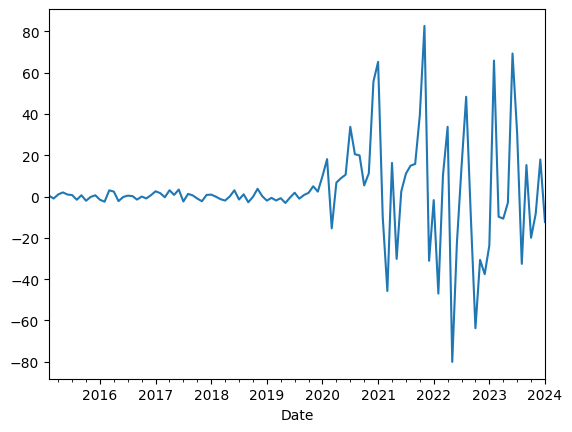

In [157]:
prev_diff = prev['Open'].resample('MS').mean() - prev['Open'].resample('MS').mean().shift(1)
prev_open_diff = prev_diff.dropna()
prev_open_diff.plot()

print(adf_test(prev_open_diff))

# Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)

another test for checking the stationarity of a time series

In [158]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=['Test Statistic', 'p-value', "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)"% key] = value
    
    print(kpss_output)

In [159]:
kpss_test(prev['High'])

Results of KPSS Test:
Test Statistic            5.841427
p-value                   0.010000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<Axes: xlabel='Date'>

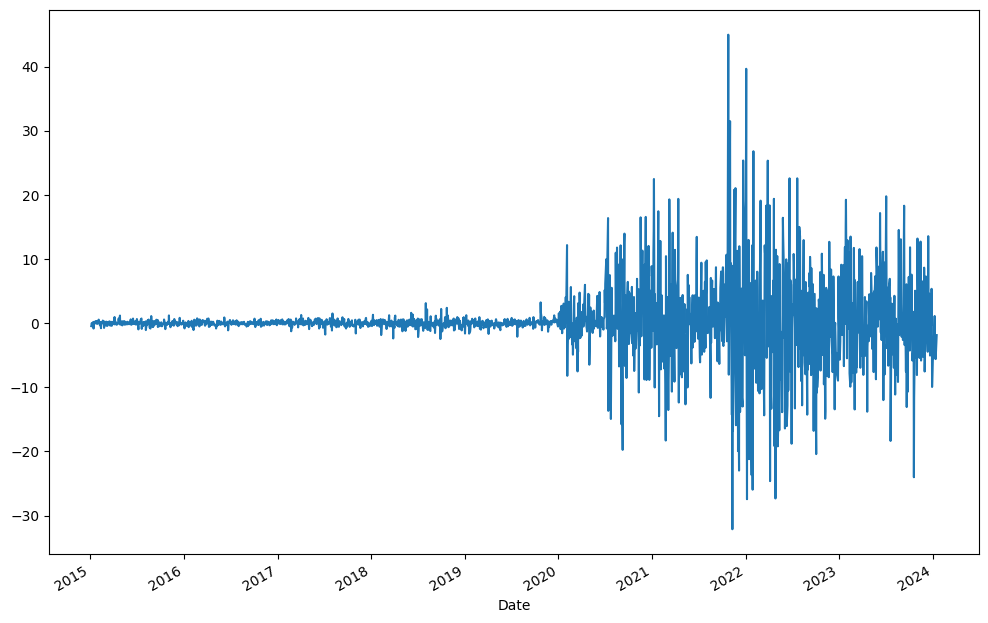

In [160]:
prev['High_diff'] = prev['High'] - prev['High'].shift(1)
prev['High_diff'].dropna().plot(figsize=(12, 8))

In [161]:
kpss_test(prev['High_diff'].dropna())

Results of KPSS Test:
Test Statistic           0.067982
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [162]:
kpss_test(prev['High_diff'].dropna())

Results of KPSS Test:
Test Statistic           0.067982
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [163]:
kpss_test(prev['High_diff'].resample('MS').mean().dropna())

Results of KPSS Test:
Test Statistic           0.094041
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [164]:
kpss_test(prev['High_diff'].resample('MS').std().dropna())

Results of KPSS Test:
Test Statistic           1.214376
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [165]:
adf_test(prev['High_diff'].dropna())

Result of Dickey-Fuller Test:
Test Statistic                -9.395753e+00
p-value                        6.381356e-16
#Lags-Used                     2.600000e+01
number of observations used    2.246000e+03
Critical Value (1%)           -3.433265e+00
Critical Value (5%)           -2.862828e+00
Critical Value (10%)          -2.567456e+00
dtype: float64


# Data Preprocessing

In [166]:
train_prev = prev['High'].iloc[:-4]

X = []
Y = []

for i in range(2, len(train_prev)):
    X.append(train_prev[i-2:i])
    Y.append(train_prev[i])

In [167]:
import math
train_len = math.ceil(len(train_prev)*0.8)
train_len

1816

In [168]:
x_train, y_train = np.array(X), np.array(Y)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build LSTM Model

In [169]:
# Function to create a more complex LSTM model
def build_lstm_model(input_shape, learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    # First LSTM layer with Batch Normalization
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    # Second LSTM layer
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(dropout_rate))
    # Third LSTM layer
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(1))
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

In [170]:
input_shape = (x_train.shape[1], 1)
model = build_lstm_model(input_shape)

In [171]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 100)            40800     
                                                                 
 batch_normalization_2 (Batc  (None, 2, 100)           400       
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                      

In [172]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [173]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, 
                    verbose=2, validation_split=0.15, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
31/31 - 4s - loss: 18147.0957 - val_loss: 47940.8086 - lr: 0.0010 - 4s/epoch - 132ms/step
Epoch 2/100
31/31 - 0s - loss: 14924.9746 - val_loss: 38180.7148 - lr: 0.0010 - 272ms/epoch - 9ms/step
Epoch 3/100
31/31 - 0s - loss: 11540.0801 - val_loss: 26901.2227 - lr: 0.0010 - 268ms/epoch - 9ms/step
Epoch 4/100
31/31 - 0s - loss: 8267.2764 - val_loss: 17837.0156 - lr: 0.0010 - 319ms/epoch - 10ms/step
Epoch 5/100
31/31 - 0s - loss: 5563.2036 - val_loss: 8765.2637 - lr: 0.0010 - 299ms/epoch - 10ms/step
Epoch 6/100
31/31 - 0s - loss: 3360.0437 - val_loss: 5681.5742 - lr: 0.0010 - 299ms/epoch - 10ms/step
Epoch 7/100
31/31 - 0s - loss: 1981.4779 - val_loss: 1278.1267 - lr: 0.0010 - 290ms/epoch - 9ms/step
Epoch 8/100
31/31 - 0s - loss: 1423.9603 - val_loss: 548.7307 - lr: 0.0010 - 293ms/epoch - 9ms/step
Epoch 9/100
31/31 - 0s - loss: 1224.5488 - val_loss: 359.6331 - lr: 0.0010 - 295ms/epoch - 10ms/step
Epoch 10/100
31/31 - 0s - loss: 850.3134 - val_loss: 149.3739 - lr: 0.0010 - 288ms/

<Axes: >

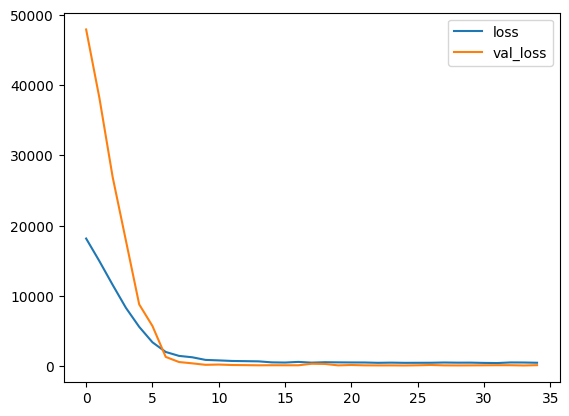

In [174]:
# loss
losses = pd.DataFrame(history.history)
losses[['loss', 'val_loss']].plot()

Prepare the validation data

In [175]:
test_data = train_prev[train_len-2:]
x_val, y_val = [], []

for i in range(2, len(test_data)):
    x_val.append(test_data[i-2:i])
    y_val.append(test_data[i])

In [176]:
x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Making Predictions

In [177]:
predictions = model.predict(x_val)

15/15 [==============================] - 1s 2ms/step


In [178]:
from sklearn.metrics import mean_squared_error
lstm_train_pred = model.predict(x_train)
lstm_val_pred = model.predict(x_val)
print('Train rmse', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation loss', np.sqrt(mean_squared_error(y_val, lstm_val_pred)))


15/15 [==============================] - 0s 2ms/step
Train rmse 7.513775672383693
Validation loss 9.03706335814074


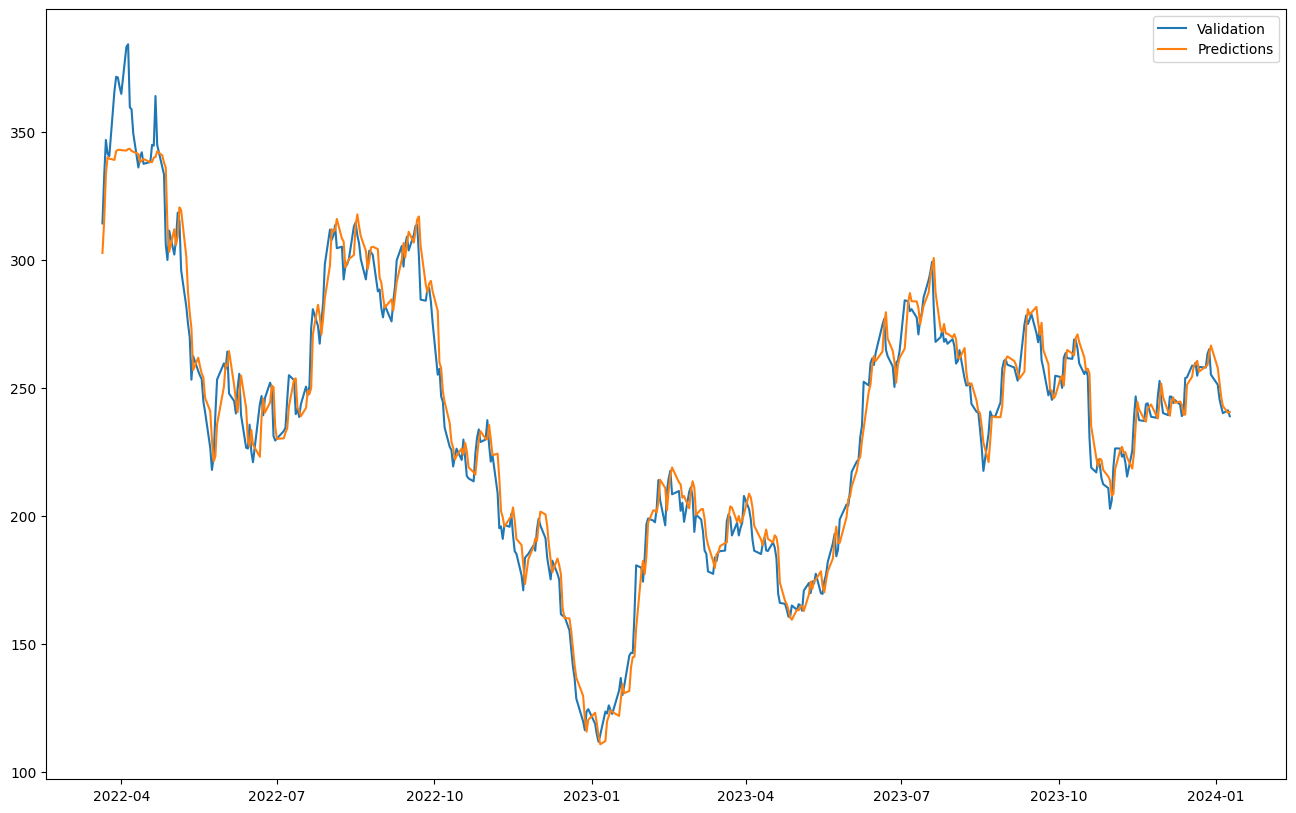

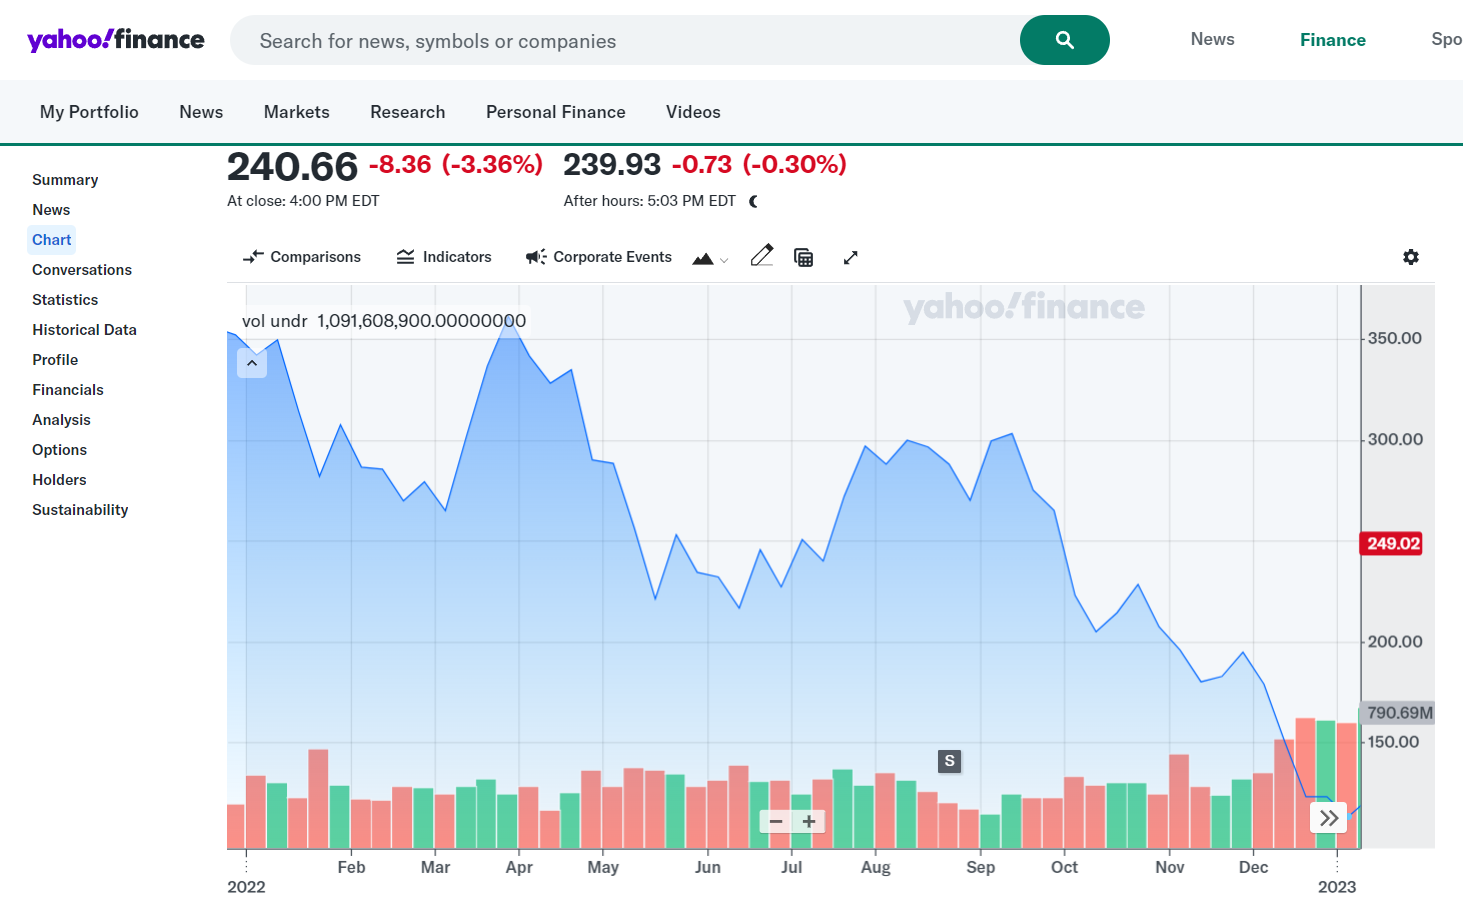

In [179]:
val = pd.DataFrame(train_prev[train_len:])
val['Predictions'] = lstm_val_pred
plt.figure(figsize=(16, 10))
plt.plot(val[['High', 'Predictions']])
plt.legend(['Validation', 'Predictions'])
plt.show()


# Compare Prediction with real Stock price for that year
from IPython.display import Image, display

# Load and dispalay the image
img = Image(filename='tesla_stock_price_2022.png')
display(img)

Error calculation between real and predicted

In [183]:
variance = []
for i in range(len(val)):
    variance.append(val['High'][i] - val['Predictions'][i])

variance = pd.DataFrame(variance)
variance.describe()

,0
count,454.000000
mean,-0.874317
std,9.004592
min,-30.154175
25%,-6.324459
50%,-1.154701
75%,3.605850
max,40.945435


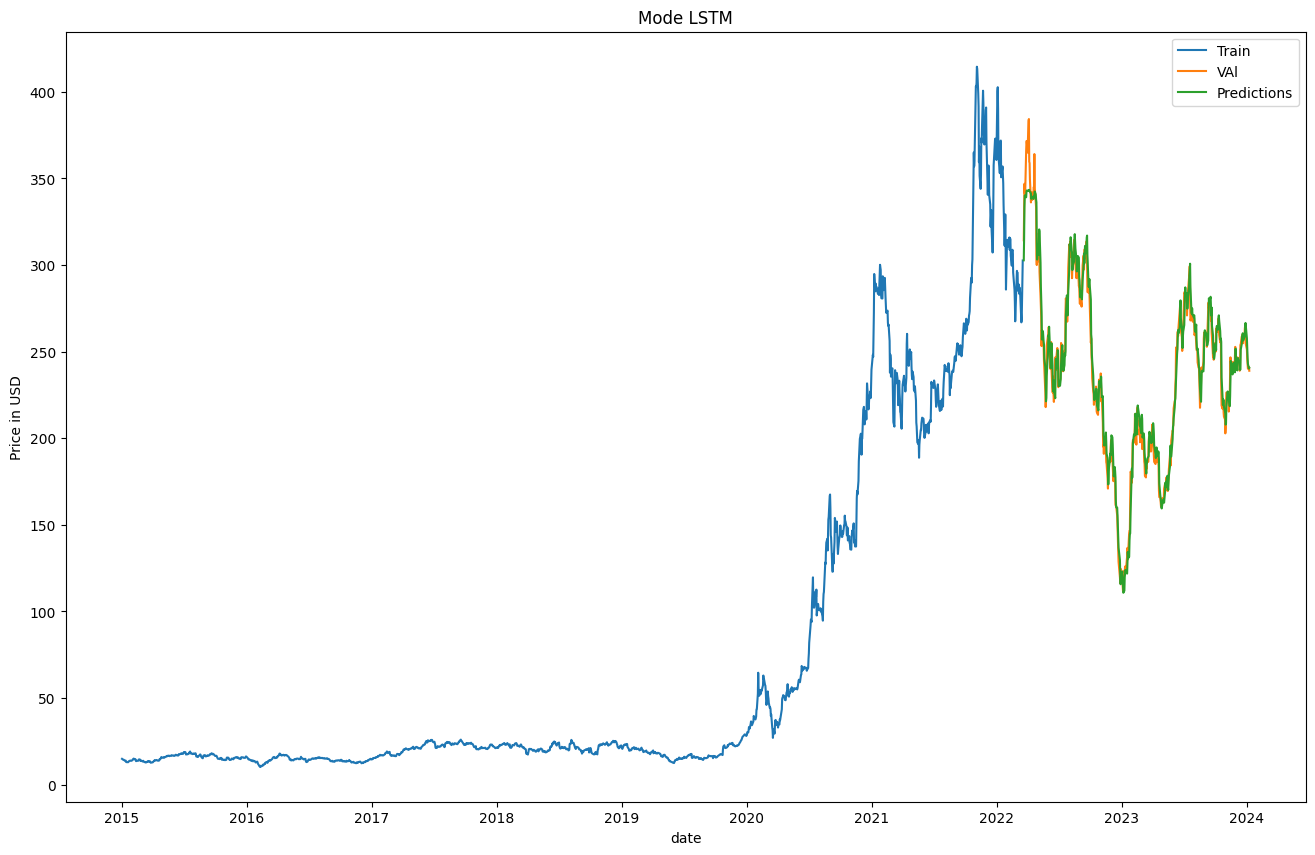

In [184]:
train = train_prev[:train_len]
val = pd.DataFrame(train_prev[train_len:])
val['Predictions'] = lstm_val_pred

plt.figure(figsize=(16, 10))
plt.title('Mode LSTM')
plt.xlabel('date')
plt.ylabel('Price in USD')
plt.plot(train)
plt.plot(val[['High', 'Predictions']])
plt.legend(['Train', 'VAl', 'Predictions'])
plt.show()

# Generate Predicitons for next 30 days

In [185]:
forecast_input = x_val[-1:]

In [208]:
def forecast_next_30_days(model, initial_data, days_to_predict=31):  # Change to 31
    prediction_list = initial_data.tolist()

    for _ in range(days_to_predict):
        x = np.array(prediction_list[-2:]).reshape(1, 2, 1)
        next_prediction = model.predict(x)[0, 0]
        prediction_list.append(next_prediction.item())

    return prediction_list[2:]

next_30_days = forecast_next_30_days(model, forecast_input.flatten(), 30)

1/1 [==============================] - 0s 31ms/step


In [209]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(existing_data, next_30_days, title="Predictions for Next 30 Days"):
    existing_data_flat = existing_data.flatten()
    total_data = np.concatenate((existing_data_flat, next_30_days))
    days = np.arange(len(total_data))

    plt.figure(figsize=(10, 6))
    plt.plot(days[:len(existing_data_flat)], existing_data_flat, label='Historical Data', color='blue')
    plt.plot(days[len(existing_data_flat):], next_30_days, label='Next 30 Days Prediction', color='red', linestyle='dashed')

    plt.xlabel('Days')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# plot_predictions(forecast_input, next_30_days)


In [213]:
# Add these prediction to 'val' DataFrame
last_date = val.index[-1]
new_dates = pd.date_range(start=last_date, periods=30)
new_predictions = pd.DataFrame(next_30_days, index=new_dates, columns=['Predictions'])

extended_val = pd.concat([val, new_predictions])

In [218]:
import plotly.graph_objects as go

# Plot the resuly using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=val.index, y=val['High'], mode='lines', name='Actual High'))
fig.add_trace(go.Scatter(x=extended_val.index, y=extended_val['Predictions'], mode='lines', name='Predictions'))

fig.update_layout(title='Tesla Price Prediction', xaxis_title='Date', yaxis_title='Price (USD)')

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [221]:
import plotly.graph_objects as go

# Sample data
x = [1, 2, 3, 4]
y = [10, 11, 12, 13]

# Create a simple figure
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Show the figure
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed